# Lab 1

All code below is referenced from Lecture_1_2.ipynb provided by Gittu George for DSCI 525

In [1]:
%conda install altair -y

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
# import packages

import altair as alt
import dask.dataframe as dd
import re
import os
import glob
import sys
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import numpy as np
from memory_profiler import memory_usage
from os import listdir
from functools import reduce

In [3]:
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype');

In [4]:
#%load_ext rpy2.ipython

In [5]:
%load_ext memory_profiler

In [6]:
# Necessary metadata
article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figshareairline/"

In [7]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  # this contains all the articles data, feel free to check it out
files = data["files"]             # this is just the data about the files, which is what we want
files

[{'is_link_only': False,
  'name': 'daily_rainfall_2014.png',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'id': 26579150,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'size': 58863},
 {'is_link_only': False,
  'name': 'environment.yml',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'id': 26579171,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'size': 192},
 {'is_link_only': False,
  'name': 'README.md',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'id': 26586554,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'size': 5422},
 {'is_link_only': False,
  'name': 'data.zip',
  'supplied_md5': 'b517383f76e77bd03755a63a8ff83ee9',
  'computed_md5': 'b517383f76e77bd03755a63a8ff83ee9',
  'id': 26766812,
  'download_url': 'https://

Next, we download the data:

In [8]:
# make directory if missing
os.makedirs(output_directory, exist_ok=True)

# download missing files
files_to_dl = ["data.zip"]
for item in filter(lambda x: x['name'] in files_to_dl, files):
    filename = os.path.join(output_directory, item["name"])
    if not os.path.isfile(filename):
        urlretrieve(item["download_url"], filename)

The download took 55 mins on Raf's computer.

In [9]:
mem = dict()

## Method 1: Pandas from ZIP Directly

In [10]:
# open a read-only connection to zip file
zfile = zipfile.ZipFile(glob.glob(output_directory + "*.zip")[0], "r")

# list non-hidden files in zip
z_csvs = list(filter(lambda x: not x.startswith("__"), zfile.namelist()))
z_csvs = [x for x in z_csvs if "observed" not in x]

In [11]:
%%time
%%memit -o

# create a dictionary of dataframes
dat = {x.split('_daily')[0]: pd.read_csv(zfile.open(x)) for x in z_csvs}

# reshape to one big dataframe
dat = pd.concat(dat, names=["model", "row"])

peak memory: 10299.13 MiB, increment: 10184.62 MiB
CPU times: user 1min 9s, sys: 7.48 s, total: 1min 17s
Wall time: 1min 18s


<MemitResult : peak memory: 10299.13 MiB, increment: 10184.62 MiB>

In [12]:
# assign memory profile to dict
mem["method 1: Pandas from Zip Directly"] = _

In [13]:
mem["method 1: Pandas from Zip Directly"]

<MemitResult : peak memory: 10299.13 MiB, increment: 10184.62 MiB>

Unfortunately, this method is very memory hungry. It requires 10,361 MB of memory.

In [14]:
print(dat.shape)

(62467843, 6)


In [15]:
dat.head()

time    lat_min    lat_max   lon_min  \
model           row                                                        
MPI-ESM-1-2-HAM 0    1889-01-01 12:00:00 -35.439867 -33.574619  141.5625   
                1    1889-01-02 12:00:00 -35.439867 -33.574619  141.5625   
                2    1889-01-03 12:00:00 -35.439867 -33.574619  141.5625   
                3    1889-01-04 12:00:00 -35.439867 -33.574619  141.5625   
                4    1889-01-05 12:00:00 -35.439867 -33.574619  141.5625   

                      lon_max  rain (mm/day)  
model           row                           
MPI-ESM-1-2-HAM 0    143.4375   4.244226e-13  
                1    143.4375   4.217326e-13  
                2    143.4375   4.498125e-13  
                3    143.4375   4.251282e-13  
                4    143.4375   4.270161e-13

## Method 2: Using Pandas on Unzipped Files

In [16]:
del dat

In [17]:
%%time

# Unzip the files
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: user 17.6 s, sys: 2.68 s, total: 20.2 s
Wall time: 21.9 s


In [18]:
# list all CSVs
csvs = glob.glob(output_directory + '*.csv')


# As per Tom's guidance, we can exclude the annoying CSV that is formatted differently
csvs = [x for x in csvs if "observed" not in x]

In [19]:
%%time
%%memit -o

# create a dictionary of dataframes
dat = {x.split('_daily')[0]: pd.read_csv(x) for x in csvs}

# reshape to one big dataframe
dat = pd.concat(dat, names=["model", "row"])

peak memory: 10334.34 MiB, increment: 4433.09 MiB
CPU times: user 57.8 s, sys: 11.4 s, total: 1min 9s
Wall time: 1min 11s


<MemitResult : peak memory: 10334.34 MiB, increment: 4433.09 MiB>

In [20]:
# assign memory profile to dict
mem["method 2: Using Pandas on Unzipped Files"] = _

In [21]:
assert dat.shape[0] == 62467843

Looking at the incremental columns, it seems that reduced the memory requirement by ~40% by using unzipped files.

## Method 3: Append, instead of Using pd.concat

In [22]:
del dat

In [23]:
%%time
%%memit -o

dat = pd.DataFrame()
for file in csvs:
    tempdf = pd.read_csv(file)
    tempdf['model'] = file.split('_daily')[0]
    dat = dat.append(tempdf)

peak memory: 12391.27 MiB, increment: 7310.06 MiB
CPU times: user 2min 12s, sys: 34.7 s, total: 2min 47s
Wall time: 2min 51s


<MemitResult : peak memory: 12391.27 MiB, increment: 7310.06 MiB>

In [24]:
# assign memory profile to dict
mem["method 3: Append, instead of pd.concat"] = _

In [25]:
dat.shape[0]

62467843

In [26]:
assert dat.shape[0] == 62467843

There is no appreciable difference in memory usage, but it is much slower than `pd.concat`.

### Method 4: Change the data type

In [27]:
# delete dat object to read it in anew
del dat

In [28]:
# define the dtypes
colspec = {"time": "str",
           "lat_min": np.float32,
           "lat_max": np.float32,
           "lon_min": np.float32,
           "lon_max": np.float32,
           "rain (mm/day)": np.float32}

In [29]:
%%time
%%memit -o

# create a dictionary of dataframes
dat = {x.split('_daily')[0]: pd.read_csv(x, dtype=colspec, parse_dates=["time"]) for x in csvs}

# reshape to one big dataframe
dat = pd.concat(dat, names=["model", "row"])

peak memory: 9475.89 MiB, increment: 4228.30 MiB
CPU times: user 1min 3s, sys: 6.61 s, total: 1min 9s
Wall time: 1min 11s


<MemitResult : peak memory: 9475.89 MiB, increment: 4228.30 MiB>

In [30]:
# assign memory profile to dict
mem["method 4: Change the dtype"] = _

In [31]:
dat.head()

time    lat_min    lat_max  \
model                           row                                             
figshareairline/MPI-ESM-1-2-HAM 0   1889-01-01 12:00:00 -35.439865 -33.574619   
                                1   1889-01-02 12:00:00 -35.439865 -33.574619   
                                2   1889-01-03 12:00:00 -35.439865 -33.574619   
                                3   1889-01-04 12:00:00 -35.439865 -33.574619   
                                4   1889-01-05 12:00:00 -35.439865 -33.574619   

                                      lon_min   lon_max  rain (mm/day)  
model                           row                                     
figshareairline/MPI-ESM-1-2-HAM 0    141.5625  143.4375   4.244226e-13  
                                1    141.5625  143.4375   4.217326e-13  
                                2    141.5625  143.4375   4.498125e-13  
                                3    141.5625  143.4375   4.251282e-13  
                                4    141.5625  143.4375   4.270161e-13

Changing the memory type to float 32 gives us a ~30% boost in our memory footprint. Timing is about the same.

## Method 5: Only Load Wanted Columns

In [32]:
del dat

In [33]:
usecols = ["time", "rain (mm/day)"]

In [34]:
%%time
%%memit -o

# create a dictionary of dataframes
dat = {x.split('_daily')[0]: pd.read_csv(x, dtype=colspec, parse_dates=["time"], usecols=usecols) for x in csvs}

# reshape to one big dataframe
dat = pd.concat(dat, names=["model", "row"])

peak memory: 9189.91 MiB, increment: 2854.07 MiB
CPU times: user 52.4 s, sys: 5.83 s, total: 58.2 s
Wall time: 59.7 s


<MemitResult : peak memory: 9189.91 MiB, increment: 2854.07 MiB>

In [35]:
# assign memory profile to dict
mem["method 5: Only load wanted columns"] = _

In [36]:
dat.head()

time  rain (mm/day)
model                           row                                   
figshareairline/MPI-ESM-1-2-HAM 0   1889-01-01 12:00:00   4.244226e-13
                                1   1889-01-02 12:00:00   4.217326e-13
                                2   1889-01-03 12:00:00   4.498125e-13
                                3   1889-01-04 12:00:00   4.251282e-13
                                4   1889-01-05 12:00:00   4.270161e-13

This step made a big difference, cutting down the memory usage by about a quarter. It gave us a small speed advantage too.

## Method 6: Chunking

In [37]:
del dat

In [38]:
%%time
%%memit -o

dat = pd.DataFrame()
for file in csvs:
    model = file.split('_daily')[0]
    for chunk in pd.read_csv(file, dtype=colspec, parse_dates=["time"], usecols=usecols,
                             chunksize=10_000_000):
        chunk['model'] = model
        dat = pd.concat([dat, chunk])

peak memory: 11410.46 MiB, increment: 4500.41 MiB
CPU times: user 1min, sys: 15 s, total: 1min 15s
Wall time: 1min 16s


<MemitResult : peak memory: 11410.46 MiB, increment: 4500.41 MiB>

In [39]:
# assign memory profile to dict
mem["method 6a: Chunking (1e7)"] = _

In [40]:
assert dat.shape[0] == 62467843

Let's try even smaller chunks:

In [41]:
del dat
del chunk
del model

In [42]:
%%time
%%memit -o

dat = pd.DataFrame()
for file in csvs:
    model = file.split('_daily')[0]
    for chunk in pd.read_csv(file, dtype=colspec, parse_dates=["time"], usecols=usecols,
                             chunksize=1_000_000):
        chunk['model'] = model
        dat = pd.concat([dat, chunk])

peak memory: 11436.25 MiB, increment: 228.57 MiB
CPU times: user 1min 15s, sys: 17.9 s, total: 1min 32s
Wall time: 1min 34s


<MemitResult : peak memory: 11436.25 MiB, increment: 228.57 MiB>

In [43]:
# assign memory profile to dict
mem["method 6b: Chunking (1e6)"] = _

In [44]:
assert dat.shape[0] == 62467843

These incremental memory results are phenomenal for chunk size of a million-- but almost too good to be true. I am not sure if I trust them completely.

## Method 7: Using Dask

In [45]:
del dat

In [46]:
%%time
%%memit -o

# define a parser to extract the model name
def parser(path):
    file = os.path.split(path)[1]
    return file.split('_daily')[0]

# read-in with dask
dat = dd.read_csv(csvs, include_path_column = "model",
                  converters = {"model": parser})

peak memory: 11196.17 MiB, increment: 0.49 MiB
CPU times: user 79.3 ms, sys: 118 ms, total: 198 ms
Wall time: 1.49 s


<MemitResult : peak memory: 11196.17 MiB, increment: 0.49 MiB>

In [47]:
# assign memory profile to dict
mem["method 7: Dask"] = _

From the profiling, it is apparent that Dask has a negligible memory footprint.

In [48]:
dat.head()

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1,1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
2,1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
3,1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
4,1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


In [49]:
%%time
%%memit

len(dat.index)

peak memory: 11293.98 MiB, increment: -2.23 MiB
CPU times: user 1min 21s, sys: 18.3 s, total: 1min 40s
Wall time: 30.8 s


We can see that a 'simple' operation of counting the number of rows took a very long time!

In [50]:
%%time
%%memit

res = (dat
       .groupby('model')['rain (mm/day)']
       .agg(["mean", "std"])
       .sort_values("mean")
       .reset_index()
       .compute()
      )
print(res)

               model      mean       std
0      MPI-ESM1-2-HR  0.995569  4.083814
1      MPI-ESM1-2-LR  1.074308  3.911700
2          KIOST-ESM  1.102353  3.852051
3         MRI-ESM2-0  1.368030  4.517987
4           GFDL-CM4  1.414485  5.024926
5   EC-Earth3-Veg-LR  1.516258  4.714335
6    MPI-ESM-1-2-HAM  1.610720  4.885519
7              NESM3  1.621936  4.971972
8        FGOALS-f3-L  1.627373  5.747396
9         ACCESS-CM2  1.787025  5.914188
10          BCC-ESM1  1.811032  5.358361
11           CanESM5  1.894328  5.835787
12       BCC-CSM2-MR  1.951832  6.200969
13    AWI-ESM-1-1-LR  2.026071  5.321889
14         FGOALS-g3  2.156419  6.015488
15       SAM0-UNICON  2.169676  6.383241
16     ACCESS-ESM1-5  2.217501  6.422397
17           TaiESM1  2.224576  5.886578
18        NorESM2-LM  2.230799  5.681562
19        NorESM2-MM  2.232966  6.151688
20         CMCC-ESM2  2.266125  5.538429
21      CMCC-CM2-HR4  2.279350  5.629965
22            MIROC6  2.301662  6.393745
23      CMCC-CM2

Calculating model-wise summaries also took a long time-- almost a minute!

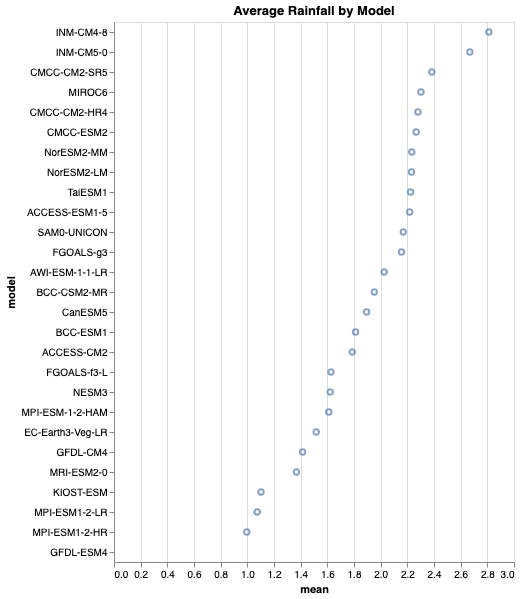

In [51]:
base = alt.Chart(res, title = "Average Rainfall by Model")
points = base.mark_point().encode(
    alt.Y("model:N", sort="-x"),
    alt.X("mean:Q")
)

points

## Summary

In [52]:
memres = dict()
for k, v in mem.items():
    memres[k] = (v.mem_usage[0] - v.baseline)

memres = pd.DataFrame(pd.Series(memres), columns=["memory"]).reset_index()

memres

,index,memory
0,method 1: Pandas from Zip Directly,10184.621094
1,method 2: Using Pandas on Unzipped Files,4433.085938
2,"method 3: Append, instead of pd.concat",7310.062500
3,method 4: Change the dtype,4228.296875
4,method 5: Only load wanted columns,2854.070312
5,method 6a: Chunking (1e7),4500.410156
6,method 6b: Chunking (1e6),228.574219
7,method 7: Dask,0.492188


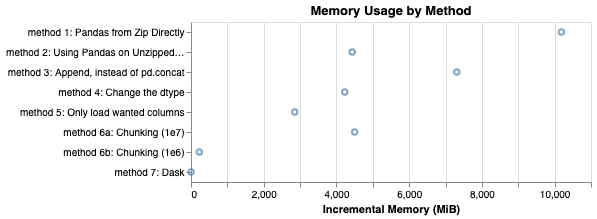

In [53]:
alt.Chart(memres, title = "Memory Usage by Method").mark_point().encode(
    alt.Y("index:N", title = ""),
    alt.X("memory:Q", title = "Incremental Memory (MiB)")
)